## Imports

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_model_optimization as tfmot
from RadixNetCalc import emr_net, kemr_net
import matlab.engine
import math
import networkx as nx

### Read data

In [3]:
data = pd.read_csv("MNIST/mnist_train.csv") #mnist train
test = pd.read_csv("MNIST/mnist_test.csv") #mnist test
data = np.array(data)
np.random.seed(100)
np.random.shuffle(data) 

data_train = data.T
Y_train = np.array(data_train[0])
X_train = np.array(data_train[1:]).T
X_train = X_train / 255

test = np.array(test)
data_test = test.T
Y_test = np.array(data_test[0])
X_test = np.array(data_test[1:]).T
X_test = X_test / 255

## Create a Mask 
Create using Mask(num_output, input_shape, radix), call using maskname()

In [4]:
class Mask(tf.Module):
    """
    A class used to create tensorflow masks that represent the RadiXNet weight masks. 
    They are used to be applied at every call of a RadixLayer, specifically at every step of training.
    ...
    Attributes
    ----------
    val : None or tf.Variable
        keeps track of what the mask is in a tensorflow format, kept as None to start with 
        but is changed the first time it's called
    layerval : np.array
        input of what the mask should be in a numpy array format.
    """
    def __init__(self,layerval:np.array):
        """
        Used to construct a Mask, but doesn't have the correct shape yet.
        Inputs:
        layerval : np.array
            input of what the mask should be in a numpy array format
        """
        self.val=None
        self.layerval = layerval
    @tf.function
    def __call__(self):
        """
        Used whenever you want to actually use the mask
        Example of usage:
            mask = Mask(layerval) #create the mask
            tf.math.multiply(kernel, mask()) #calling the mask
        """
        if self.val is None:
            #arr = np.zeros(self.input_shape[1:]+(self.num_outputs,))
            arr = self.layerval
            tensor = tf.constant(arr, dtype= tf.float32)
            self.val = tf.Variable(tensor)
        return self.val
        

### RadixLayer

In [5]:
class RadixLayer(layers.Layer):
    """
    A class used to create layers of a RadiXNet, made for an easier implementation of RadiXNets
    ...
    Attributes
    ----------
    num_outputs : int
        the number of outputs that the layer should have, or how many neurons are in the next layer
    layerval : numpy array
        input of what the mask should be in a numpy array format
    kernel : tensorflow Variable
        the values of the layer that will be trained
    """
    def __init__(self, num_outputs:int, layerval:np.array):
        """
        Used to construct a RadixLayer
        Inputs:
        num_outputs : int
            number of outputs that layer should have
        layerval : numpy array
            input of what the mask should be
        """
        super(RadixLayer,self).__init__()
        self.num_outputs = num_outputs
        self.layerval = layerval
    def build(self, input_shape:tuple):
        """
        Used when first creating and calling a RadixLayer, creates the kernel variable
        Inputs:
        input_shape : tuple
            Size of inputs, this is needed in the build function but is currently not used because our kernel 
            shapes should take on the shape of the radix layer
        """
        self.kernel = self.add_weight("kernel", shape = self.layerval.shape, initializer='random_normal', trainable=True)
    def call(self, inputs:tf.Tensor):
        """
        Used whenever the RadixLayer is called during iterations
        Inputs:
        inputs: tensor
            What will be going into the RadiXLayer
        Outputs:
            returns the inputs matrix multiplied with a masked version of the kernel (element wise multiplication between kernel and mask)
        """
        mask = Mask(self.layerval)
        masked = tf.math.multiply(self.kernel,mask())
        #extrazero =  tf.zeros(shape=(self.layerval.shape[0]-inputs.shape[1]), dtype=tf.int32)
        #inputs = tf.concat(inputs,extrazero)
        try:
            return tf.matmul(inputs,masked)
        except:
            return None

# Custom Model (Customize)

In [10]:
"""
Change what N, B, and desired is to have custom radices and kronecker numbers to fit a specific network
Then adjust CustomModel class to fit in with how many layers you have and what activation functions you want
"""
# N = [[5,2], [1]]    
# B = [79, 30, 10, 1]
N = [[10,10], [10]]    
B = [8, 3, 1, 1]
desired = [784,300,100,10]
rlayers = kemr_net(N,B)
for i in range(len(rlayers)):
    if rlayers[i].shape[0]>desired[i]:
        rlayers[i] = rlayers[i][:desired[i],:]
    if rlayers[i].shape[1]>desired[i+1]:
        rlayers[i] = rlayers[i][:,:desired[i+1]]
class CustomModel(tf.keras.Model):
    """
    Class used to customize whatever kind of model the user would like
    ...
    Attributes
    ----------
    layers : RadixLayer
        However many RadixLayers the user would like, take in from rlayers, which is done with kemr_net and trimming to the desired size
    """
    def __init__(self, rlayers:list):
        """
        Initialization of layers (choose how many layers you want)
        Inputs:
        rlayers : list of numpy arrays
            fully created rlayers from kemr_net and trimmed to fit desired
        """
        super(CustomModel,self).__init__()
        self.layer1 = RadixLayer(rlayers[0].shape[-1], rlayers[0])
        self.layer2 = RadixLayer(rlayers[1].shape[-1],rlayers[1])
        self.layer3 = RadixLayer(rlayers[2].shape[-1],rlayers[2])
    def call(self, input_tensor:tf.Tensor):
        """
        Actually does the math and calculates the result of an input through the network.
        Customize what activation functions are used
        Inputs:
        input_tensor : tensor
            the input
        Outputs:
            The result of the calculation
        """
        x= tf.nn.relu(self.layer1(input_tensor))
        x= tf.nn.relu(self.layer2(x))
        x= tf.nn.softmax(self.layer3(x))
        return x
    

### Sparsity Calculation

In [7]:
def calculate_sparsity(sparselayers:list):
    """
    Calculates the sparsity of a Radix Network
    Inputs: 
    sparselayers : list of numpy arrays
        The radix layers that you want to check the sparsity of (the masks specifically)
    Outputs:
        A double that gives the sparsity of the network
    """
    a = 0
    b = 0
    for layer in sparselayers:
        a += np.count_nonzero(layer)
        b += np.prod(layer.shape)
    try:
        return 1 - a/b
    except:
        return -1

sparsity = calculate_sparsity(rlayers)

Sparsity: 0.9


### Compiling of model

In [8]:
model = CustomModel(rlayers)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2023-07-20 15:27:07.831936: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-20 15:27:07.831956: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-20 15:27:07.831981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d-5-2-3): /proc/driver/nvidia/version does not exist
2023-07-20 15:27:07.832209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training

In [9]:
epochs = 10
history = model.fit(X_train,Y_train,epochs = epochs, batch_size = 20,validation_split = 0.1)

Epoch 1/10
1890/1890 [==============================] - 5s 2ms/step - loss: 0.5848 - accuracy: 0.8473 - val_loss: 0.2805 - val_accuracy: 0.9207
Epoch 2/10
1890/1890 [==============================] - 4s 2ms/step - loss: 0.2534 - accuracy: 0.9265 - val_loss: 0.2295 - val_accuracy: 0.9383
Epoch 3/10
1890/1890 [==============================] - 4s 2ms/step - loss: 0.2056 - accuracy: 0.9408 - val_loss: 0.2007 - val_accuracy: 0.9469
Epoch 4/10
1890/1890 [==============================] - 4s 2ms/step - loss: 0.1774 - accuracy: 0.9482 - val_loss: 0.1913 - val_accuracy: 0.9488
Epoch 5/10
1890/1890 [==============================] - 4s 2ms/step - loss: 0.1561 - accuracy: 0.9552 - val_loss: 0.1832 - val_accuracy: 0.9493
Epoch 6/10
1890/1890 [==============================] - 4s 2ms/step - loss: 0.1408 - accuracy: 0.9585 - val_loss: 0.1714 - val_accuracy: 0.9531
Epoch 7/10
1890/1890 [==============================] - 4s 2ms/step - loss: 0.1263 - accuracy: 0.9623 - val_loss: 0.1666 - val_accuracy:

## Plotting accuracy

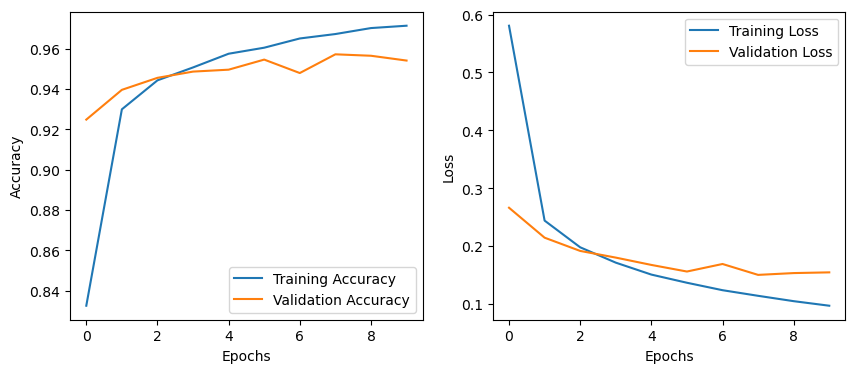

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Testing

In [104]:
test_loss, test_acc = model.evaluate(X_test,Y_test)
print(test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.1204 - accuracy: 0.9657
0.9656965732574463


### Plot Structure (Adjacency Matrix)

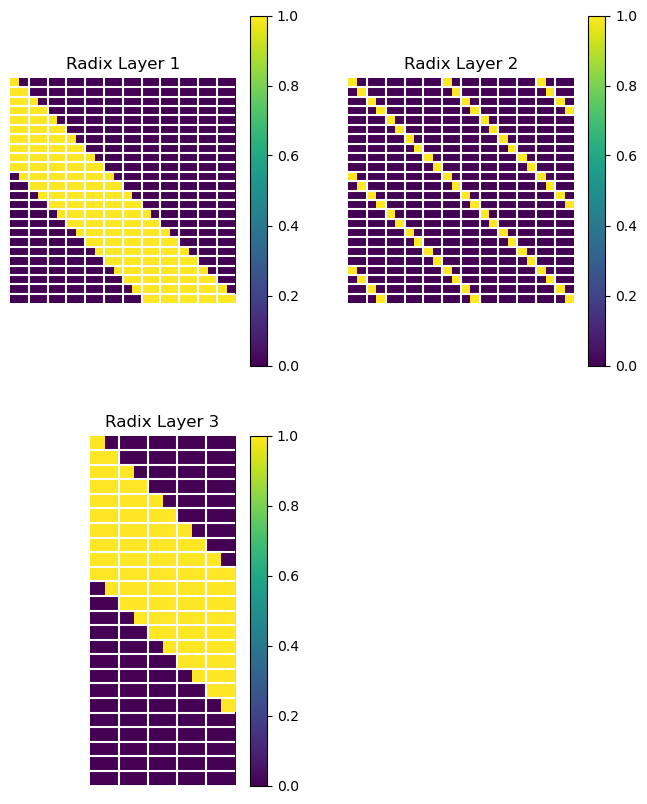

In [10]:
def plot_separation_lines(height:int, width:int):
    """
    Plots white separation lines for the adjacency matrix
    Inputs:
    height : int
        height of what will be plotted for the adjacency matrix
    width : int
        width of what will be plotted for the adjacency matrix
    """
    block_size = [1, 2]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')
def plot_layer(layerarr:list, index:int):
    """
    Plots a specific layer as an adjacency matrix
    Inputs:
    layerarr : list of numpy arr
        list of the the mask of the layers being plotted
    index : int
        gives which layer in the layer array will be plotted
    """
    tensor_data = layerarr[index]
    # The value 24 is chosen for convenience.
    smallest = min(tensor_data.shape[0],tensor_data.shape[1])
    # height = min(24,smallest)
    # width = min(24,smallest)
    height = min(24,tensor_data.shape[0])
    width = min(24,tensor_data.shape[1])
    
    subset_values_to_display = tensor_data[0:height, 0:width]
    
    val_ones = np.ones([height, width])
    val_zeros = np.zeros([height, width])
    subset_values_to_display = np.where(abs(subset_values_to_display) > 0, val_ones, val_zeros)

    plot_separation_lines(height, width)

    plt.axis('off')
    plt.imshow(subset_values_to_display)
    plt.colorbar()
    plt.title("Radix Layer "+str(index+1))

plt.figure(figsize=(math.ceil(len(rlayers)/2)*4, 10))
for i in range(len(rlayers)):
    #print(rlayers[i])
    plt.subplot(math.ceil(len(rlayers)/2),2,i+1)
    plot_layer(rlayers, i)
plt.show()

# tlayers = emr_net(N)
# plt.figure(figsize=(math.ceil(len(tlayers)/2)*4, 10))
# for i in range(len(tlayers)):
#     #print(rlayers[i])
#     plt.subplot(math.ceil(len(tlayers)/2),2,i+1)
#     plot_layer(tlayers, i)
# plt.show()

### Plot Structure (Graphical)

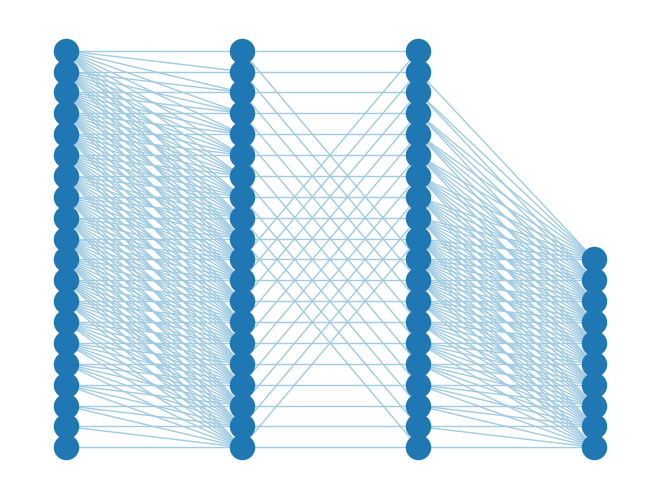

In [27]:
"""
Plots a graphical representation of the RadiXNet, adjust how much you want to see of the network with maxnodes.
Warning: too high of a maxnodes may images that are difficult to decipher where the connections lie.
"""
maxnodes = 20

B = nx.Graph()
pos = dict()
for i in range(len(rlayers)):
    temp = []
    for j in range(min(maxnodes,rlayers[i].shape[0])):
        node = "l"+str(i)+"_"+str(j)
        temp.append(node)
        pos[node]=(i,j)
    B.add_nodes_from(temp)
    
for j in range(min(maxnodes,rlayers[len(rlayers)-1].shape[1])):
        node = "l"+str(len(rlayers))+"_"+str(j)
        temp.append(node)
        pos[node]=(len(rlayers),j)
        B.add_nodes_from([node])

for a in range(len(rlayers)):
    layera = rlayers[a]
    for i in range(min(maxnodes,layera.shape[0])):
        for j in range(min(maxnodes,layera.shape[1])):
            if layera[i][j]:
                nodei = "l"+str(a)+"_"+str(i)
                nodej = "l"+str(a+1)+"_"+str(j)
                B.add_edge(nodei,nodej, color='#A0CBE2')
colors = nx.get_edge_attributes(B,'color').values()
nx.draw(B, pos=pos, edge_color=colors)
plt.show()

#### Sanity Check

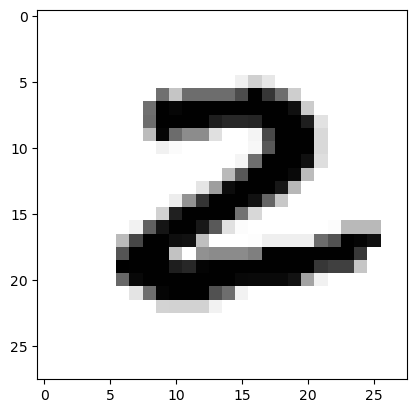

1/1 [==============================] - 0s 100ms/step
[[4.85254326e-09 1.98742526e-07 9.99999642e-01 1.56025152e-07
  4.34610403e-15 2.61873552e-12 1.29605476e-11 1.97650962e-09
  5.50332091e-09 4.19578803e-16]]


In [39]:
plt.imshow(X_train[2].reshape(28, 28), cmap=plt.cm.binary)
plt.show()
q = model.predict(np.array([X_train[2],]))
print(q)